# Assignment PA3c

The primary purpose of this program is to do sentiment analysis on the given dataset which is restaurant reviews. This is a supervised learning machine learning application. Sentiment analysis means determining the given text if the review represents positive feelings or negative ones.  Program modularized as much as possible. Still, there can be some improvements such as the code is still in notebook (.ipybn) type and not convenient to run in some of the IDEs. Main steps are defined below.

Main Steps:

1. Reading Dataset Files

undefined.  Analyze Dataset

undefined. Preprocessing

        3.1 SentimentIntensityAnalyzer

        3.2 Removing  Stop Words

        3.3 Cleaning the Text

        3.4 Lemmezation

        3.5 Handling Annotators

4. Splitting Data Into Train & Test

undefined. Distribution of Sentiment Values

undefined. Analysis of The Preprocessed Data

undefined. Model Selection and Cross Validation

undefined. Hyperparameter Selection

undefined. Running Best Model

undefined. Observing Changes After Adding New Training Dataset 

undefined. Confusion Matrix

In [1]:
#Imports
#import numpy as np
import re
import gc
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix

import math
import pandas as pd
import string

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm 
import matplotlib.pyplot as plt


In [2]:
# Define a function to read in data from a file
def reading_input(path):
    # Create a DataFrame from the data in the file
    df = pd.read_csv(path, delimiter='\t',header=None, names=['sentiment', 'reviews'])

    # Ensure that the data in both columns is of string type
    df['reviews'] = df['reviews'].astype(str) 
    df['sentiment'] = df['sentiment'].astype(str)
    
    # Print the first five rows of the DataFrame
    print(df.head())

    # Return the DataFrame
    return df

In [3]:
# Read in the training and test datasets using the reading_input function
df_train = reading_input('PA3train.tsv')
df_test = reading_input('PA3_test.tsv')

  sentiment                                            reviews
0       0/0  Ordered my food the hole meal looked dead. pla...
1       1/1  We stopped her whilst walking in the Haga area...
2       0/0  Bad experience, On 23/03/19 Myself and my part...
3       0/0  Extremely underwhelming experience here last n...
4       0/0  Waited 30 minutes to get a table…that was ok. ...
  sentiment                                            reviews
0         0  Over all I felt a bit disappointing with above...
1         1                            A wonderful experience!
2         1  Always very delicious dishes and attentive ser...
3         1                                  Amazing as always
4         1  Amazing food, the aubergine mess and the Tunis...


Training Dataset has two annotations. These confusion is handled in preprocessing part. 

In [4]:
df_test

,sentiment,reviews
0,0,Over all I felt a bit disappointing with above...
1,1,A wonderful experience!
2,1,Always very delicious dishes and attentive ser...
3,1,Amazing as always
4,1,"Amazing food, the aubergine mess and the Tunis..."
...,...,...
1746,0,Ordered Pad se eww. Food was extremely bland. ...
1747,1,Really authentic polish restaurant. The dumpli...
1748,1,We showed up 30 minutes before closing. Not on...
1749,0,We visited on Christmas eve and waved to 3 dif...


There is nothing to do with the test dataset annotations since it is in the desired form. 

In [5]:
# Print information about the training DataFrame
df_train.info()
# No missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7018 entries, 0 to 7017
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  7018 non-null   object
 1   reviews    7018 non-null   object
dtypes: object(2)
memory usage: 109.8+ KB


There is no null object in the both dataset.

In [7]:
df_train # There are 8 mismatching annotators

,sentiment,reviews
0,0/0,Ordered my food the hole meal looked dead. pla...
1,1/1,We stopped her whilst walking in the Haga area...
2,0/0,"Bad experience, On 23/03/19 Myself and my part..."
3,0/0,Extremely underwhelming experience here last n...
4,0/0,Waited 30 minutes to get a table…that was ok. ...
...,...,...
7013,0/0,"Bad service, stay away"
7014,0/0,"Old school, but not always in a good way. Lots..."
7015,1/1,Top 5 allergen free restaurant and the food is...
7016,-1/0,"The ambiance is ok, the service is slightly sl..."


 The 5.6% of data entries are noisy as you see below and above. These are the types that are not in ('0/0', '0/1', '1/0', '1/1' ) Noisy annotators are reannotated in the preprocess_sentiment() function. 

In [8]:
df_train["sentiment"].unique()


array(['0/0', '1/1', '1/0', '-1/0', '-1/1', '0/1', '2/1', '2/0', '1/',
       '9/1'], dtype=object)

In [9]:
df_train["sentiment"].value_counts().to_dict()


{'1/1': 3496,
 '0/0': 3126,
 '1/0': 148,
 '0/1': 117,
 '-1/0': 97,
 '-1/1': 28,
 '2/0': 2,
 '2/1': 2,
 '1/': 1,
 '9/1': 1}

The preprocessing part starts here. Noisy data is handled by reannotating using Sentiment Intensity Analyzer. The sentiment Intensity Analyzer gives scores if the given text is positive, negative, neutral, or compound. 

Some stop words are  “a”, “an”, “the”, “in”, “is”, “are” and “which”. These stop words have no effect on sentiment analysis. 

Clean text function removes if text have html tags, punctuations, digits, brackets, paranthesis and so on. 

Lemmatization is a text preprocessing technique that reduces words to their base or root form. For example, the verb “running” would be reduced to its base form “run”.

In [10]:
#NTLK Sentiment Intensity Analyzer Polarity Scores gives if the text/word is
#positive, negative, neutral or compound by providing scores for each class
#nltk.downloader.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('omw-1.4')
sentiment_analyzer = SentimentIntensityAnalyzer()

def get_sentiment(sentence):
    """
    Returns the polarity scores of a sentence using the NLTK Sentiment Intensity Analyzer.

    Args:
    - sentence (str): the input sentence.

    Returns:
    A dictionary containing the polarity scores for positive, negative, neutral, and compound.
    """
    sentiment_score = sentiment_analyzer.polarity_scores(sentence)
    return sentiment_score

#Stop words are deleted
def remove_stop_words(text):
    """
    Removes stop words from a piece of text.

    Args:
    - text (str): the input text.

    Returns:
    The input text with all stop words removed.
    """
    stop_words = set(stopwords.words("english"))
    words = [word for word in text.split() if word not in stop_words]
    return ' '.join(words)

#data cleaning
def clean_text(sentence):  
    """
    Cleans a sentence by removing HTML tags, special characters, square brackets, and numbers.

    Args:
    - sentence (str): the input sentence.

    Returns:
    The cleaned sentence.
    """
    sentence = sentence.lower()
    text = BeautifulSoup(sentence, "html.parser").get_text() 
    pattern=r'[^a-zA-z0-9\s]'                
    text = re.sub(pattern,'',text)
    text = re.sub('\[[^]]*\]', '', text)    
    text = re.sub(r'\d+',"", text)
    return text
    
def lemmatization(sentence):
    lemmatizer = WordNetLemmatizer()
    sentence = [lemmatizer.lemmatize(t) for t in word_tokenize(sentence) if len(t) > 1]
    sentence = ' '.join(sentence)
    return sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


We got 3 types of datasets. Training, Test, and Training Final. All of them have a different number of annotators. preprocess_sentiment function handles all three different target annotators. It also handles wrongly inputted annotators using gen_sentiment_score and get_sentiment functions. It does not matter what the annotator is, the correct annotation is given here, and that increases the reliability of the program.

In [11]:
#Mismacthing are handled according to polarity score
#For the voting method, 1 or -1 scores are given

def get_sentiment_score(text):
    """
    Determines the sentiment score of a piece of text based on its polarity scores.

    Args:
    - text (str): the input text.

    Returns:
    1 if the text is most probably positive, 0 if it is most probably negative, and 1 by default.
    """

    sentiment_score = get_sentiment(text)
    if sentiment_score['pos'] > sentiment_score['neg']:
        return 1  # Text is most probably positive
    elif sentiment_score['pos'] < sentiment_score['neg']:
        return 0  # Text is most probably negative
    else:
        return 1  # Default to positive sentiment
 
def preprocess_sentiment(text,sentiment):
    
    """
    Determines the sentiment of a piece of text based on the input sentiment labels.

    Args:
    - text (str): the input text.
    - sentiment (str): the sentiment labels provided by the annotators.

    Returns:
    The sentiment score of the text, which is either 1, 0, or determined by the NLTK Sentiment Intensity Analyzer.
    """
    
    num_annotators = len(sentiment)

    #handle test dataset
    if num_annotators == 1:
        return int(sentiment)
    #When there is 2 annotators
    elif num_annotators == 3:
        if sentiment == '0/0':
            return 0
        elif sentiment == '1/1':
            return 1
        else: # 0/1 or 1/0
            return get_sentiment_score(text)

    # Handle cases with three annotators
    elif num_annotators == 5:
        if sentiment in ['0/0/0', '0/0/1', '0/1/0']:
            return 0
        elif sentiment in ['0/1/1', '1/0/0']:
            return get_sentiment_score(text)
        elif sentiment in ['1/0/1', '1/1/0', '1/1/1']:
            return 1
        else:
            return get_sentiment_score(text)
    
    # Handle empty or unknown sentiment
    else:
        return get_sentiment_score(text)
    
    """
    Determines the sentiment of a piece of text based on the input sentiment labels.

    Args:
    - text (str): the input text.
    - sentiment (str): the sentiment labels provided by the annotators.

    Returns:
    The sentiment score of the text, which is either 1, 0, or determined by the NLTK Sentiment Intensity Analyzer.
    """
    
    num_annotators = len(sentiment)

    #handle test dataset
    if num_annotators == 1:
        return int(sentiment)
    #When there is 2 annotators
    elif num_annotators == 3:
        if sentiment == '0/0':
            return 0
        elif sentiment == '1/1':
            return 1
        else: # 0/1 or 1/0
            return get_sentiment_score(text)

    # Handle cases with three annotators
    elif num_annotators == 5:
        if sentiment in ['0/0/0', '0/0/1', '0/1/0']:
            return 0
        elif sentiment in ['0/1/1', '1/0/0']:
            return get_sentiment_score(text)
        elif sentiment in ['1/0/1', '1/1/0', '1/1/1']:
            return 1
        else:
            return get_sentiment_score(text)
    
    # Handle empty or unknown sentiment
    else:
        return get_sentiment_score(text)

All the functions above are applied under preprocessing function. Also,  There were 20 duplicates are removed. Strip method cleans the whitespaces ("space characters ") from the start and end of the word.

In [12]:
# All preprocessing methods are handled here including deleting duplicates. 
def preprocessing(data):
    # Create a new DataFrame with columns 'sentiment' and 'reviews'
    preprocess_df = pd.DataFrame(columns=['sentiment', 'reviews'])
    
    # Clean the text and remove stop words from the 'reviews' column of the input data
    preprocess_df['reviews'] = data['reviews'].apply(clean_text).apply(remove_stop_words)
    
    # Drop any duplicate rows from the data and reset the index of the resulting DataFrame
    preprocess_df = preprocess_df.drop_duplicates().reset_index(drop=True)
    
    # Strip any leading/trailing white space from the 'sentiment' column of the input data
    preprocess_df['sentiment'] = data.apply(lambda x: x.str.strip())
    
    # Apply the 'preprocess_sentiment' function to the 'reviews' and 'sentiment' columns of the input data
    preprocess_df['sentiment'] = data.apply(lambda row: preprocess_sentiment(row['reviews'], row['sentiment']), axis=1)
    
    # Lemmatize the text in the 'reviews' column of the input data
    preprocess_df['reviews'] = data.apply(lambda row: lemmatization(row['reviews']), axis=1)

    # Return the preprocessed DataFrame
    return preprocess_df

The preprocessing method is applied to both the test and training datasets. After that, both datasets are split into X(features or text) and y (target feature). There is no technique used for splitting the data because it is split beforehand.

In [13]:
# Apply the 'preprocessing' function to the 'df_train' DataFrame and split the resulting data into features and labels
df_train = preprocessing(df_train)
X_train = df_train['reviews']
y_train = df_train['sentiment']

# Apply the 'preprocessing' function to the 'df_test' DataFrame and split the resulting data into features and labels
df_test = preprocessing(df_test)
X_test = df_test['reviews']
y_test = df_test['sentiment']

/shared-libs/python3.9/py-core/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


As seen below, the training dataset is quite balanced because the number of positive and negative labels are close to each other. 

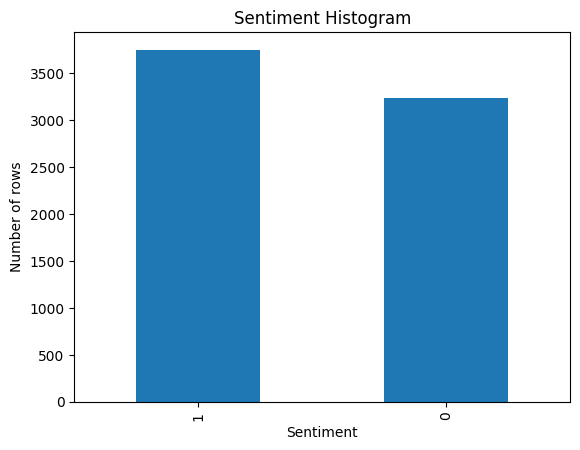

In [14]:
# Create a bar plot showing the distribution of sentiment values in the training data
plt.figure()
pd.value_counts(y_train).plot.bar(title = "Sentiment Histogram")
plt.xlabel("Sentiment")
plt.ylabel("Number of rows")
plt.show()

In [15]:
df_train

,sentiment,reviews
0,0,Ordered my food the hole meal looked dead plai...
1,1,We stopped her whilst walking in the Haga area...
2,0,Bad experience On 23/03/19 Myself and my partn...
3,0,Extremely underwhelming experience here last n...
4,0,Waited 30 minute to get table…that wa ok Sat a...
...,...,...
6981,1,My first visit and absolutely love everything ...
6982,1,Came with my friend to celebrate and we were o...
6983,0,Had to go find waiter time for service Had dif...
6984,1,Great outside space with comfy seating perfect...


In [16]:
df_test

,sentiment,reviews
0,0,Over all felt bit disappointing with above rea...
1,1,wonderful experience
2,1,Always very delicious dish and attentive service
3,1,Amazing a always
4,1,Amazing food the aubergine mess and the Tunisi...
...,...,...
1742,0,Food wa average Service wa cold The restaurant...
1743,1,Great destination for day trip take ride get o...
1744,1,After eating pastry every morning at many loca...
1745,1,Lovely staff and so kind to our dog


To compare and select the best models with the best vectorizer, many classifiers are built and evaluated here using accuracy and cross-validation scores.  These models are baseline (dummy), multinomial naive Bayes, linear support vector classifier, and perceptron. Both TFIDF and Count vectorizer are applied for each classifier model. 

In [17]:
# Define a function to create and evaluate a dummy classifier model using TF-IDF vectorization
def dummyy_classifier_model_tfidf(X_train, y_train,X_test, y_test):
    # Create a pipeline with a TF-IDF vectorizer and a dummy classifier
    pipe_dummyclf_tfidf = Pipeline([('tfidfvect', TfidfVectorizer()),
                                    ('clf',DummyClassifier()) 
                                   ])
    
    # Fit the pipeline to the training data
    pipe_dummyclf_tfidf.fit(X_train, y_train)
    
    # Use the fitted pipeline to make predictions on the test data
    y_pred = pipe_dummyclf_tfidf.predict(X_test)
    
    # Print the classification report for the test data
    print(classification_report(y_test, y_pred,zero_division=1))

# Define a function to create and evaluate a dummy classifier model using Count vectorization
def dummyy_classifier_model_count(X_train, y_train,X_test, y_test):
    # Create a pipeline with a Count vectorizer and a dummy classifier
    pipe_dummyclf_count_vec = Pipeline([
                                        ('countVect', CountVectorizer()),
                                        ('clf', DummyClassifier())
                                       ])
    
    # Fit the pipeline to the training data
    pipe_dummyclf_count_vec.fit(X_train, y_train)
    
    # Use the fitted pipeline to make predictions on the test data
    y_pred = pipe_dummyclf_count_vec.predict(X_test)
    
    # Print the classification report for the test data
    print(classification_report(y_test, y_pred,zero_division=1))

# Define a function to create and evaluate a MultinomialNB classifier model using TF-IDF vectorization
def multinomialNB_classifier_model_tfidf(X_train, y_train,X_test, y_test):
    # Create a pipeline with a TF-IDF vectorizer and a MultinomialNB classifier
    pipe_multinomialNB = Pipeline([('tfidfvect', TfidfVectorizer()),
                                   ('clf',MultinomialNB()) 
                                  ])
    
    # Perform 5-fold cross-validation on the training data using the pipeline
    scores = cross_val_score(pipe_multinomialNB, X_train, y_train, cv=5)
    
    # Print the mean and standard deviation of the cross-validation scores
    print(f'Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})')
    
    # Fit the pipeline to the training data
    pipe_multinomialNB.fit(X_train, y_train)
    
    # Use the fitted pipeline to make predictions on the test data
    y_pred = pipe_multinomialNB.predict(X_test)
    
    # Print the classification report for the test data
    print(classification_report(y_test, y_pred))

# Define a function to create and evaluate a MultinomialNB classifier model using Count vectorization
def multinomialNB_classifier_model_count(X_train, y_train,X_test, y_test):
    # Create a pipeline with a Count vectorizer and a MultinomialNB classifier
    pipe_multinomialNB = Pipeline([('countVect', CountVectorizer()),
                                   ('clf',MultinomialNB()) 
                                  ])
    
    # Perform 5-fold cross-validation on the training data using the pipeline
    scores = cross_val_score(pipe_multinomialNB, X_train, y_train, cv=5)
    
    # Print the mean and standard deviation of the cross-validation scores
    print(f'Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})')
    
    # Fit the pipeline to the training data
    pipe_multinomialNB.fit(X_train, y_train)
    
    # Use the fitted pipeline to make predictions on the test data
    y_pred = pipe_multinomialNB.predict(X_test)
    
    # Print the classification report for the test data
    print(classification_report(y_test, y_pred))

# Define a function to create and evaluate a LinearSVC classifier model using TF-IDF vectorization
def linearSVC_classifier_model_tfidf(X_train, y_train,X_test, y_test):
    # Create a pipeline with a TF-IDF vectorizer and a LinearSVC classifier
    pipe_linearSVC = Pipeline([('tfidfvect', TfidfVectorizer()),
                               ('clf',LinearSVC()) 
                              ])
    
    # Perform 5-fold cross-validation on the training data using the pipeline
    scores = cross_val_score(pipe_linearSVC, X_train, y_train, cv=5)
    
    # Print the mean and standard deviation of the cross-validation scores
    print(f'Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})')
    
    # Fit the pipeline to the training data
    pipe_linearSVC.fit(X_train, y_train)
    
    # Use the fitted pipeline to make predictions on the test data
    y_pred = pipe_linearSVC.predict(X_test)
    
    # Print the classification report for the test data
    print(classification_report(y_test, y_pred))

# Define a function to create and evaluate a LinearSVC classifier model using Count vectorization
def linearSVC_classifier_model_count(X_train, y_train,X_test, y_test):
    # Create a pipeline with a Count vectorizer and a LinearSVC classifier
    pipe_linearSVC = Pipeline([('countVect', CountVectorizer()),
                               ('clf',LinearSVC()) 
                              ])
    
    # Perform 5-fold cross-validation on the training data using the pipeline
    scores = cross_val_score(pipe_linearSVC, X_train, y_train, cv=5)
    
    # Print the mean and standard deviation of the cross-validation scores
    print(f'Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})')
    
    # Fit the pipeline to the training data
    pipe_linearSVC.fit(X_train, y_train)
    
    # Use the fitted pipeline to make predictions on the test data
    y_pred = pipe_linearSVC.predict(X_test)
    
    # Print the classification report for the test data
    print(classification_report(y_test, y_pred))

# Define a function to create and evaluate a Perceptron classifier model using TF-IDF vectorization
def perceptron_classifier_model_tfidf(X_train, y_train,X_test, y_test):
    # Create a pipeline with a TF-IDF vectorizer and a Perceptron classifier
    pipe_perceptron = Pipeline([('tfidfvect', TfidfVectorizer()),
                                ('clf',Perceptron()) 
                               ])
    
    # Perform 5-fold cross-validation on the training data using the pipeline
    scores = cross_val_score(pipe_perceptron, X_train, y_train, cv=5)
    
    # Print the mean and standard deviation of the cross-validation scores
    print(f'Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})')
    
    # Fit the pipeline to the training data
    pipe_perceptron.fit(X_train, y_train)
    
    # Use the fitted pipeline to make predictions on the test data
    y_pred = pipe_perceptron.predict(X_test)
    
    # Print the classification report for the test data
    print(classification_report(y_test, y_pred))

# Define a function to create and evaluate a Perceptron classifier model using Count vectorization
def perceptron_classifier_model_count(X_train, y_train,X_test, y_test):
    # Create a pipeline with a Count vectorizer and a Perceptron classifier
    pipe_perceptron = Pipeline([('countVect', CountVectorizer()),
                                ('clf',Perceptron()) 
                               ])
    
    # Perform 5-fold cross-validation
    scores = cross_val_score(pipe_perceptron, X_train, y_train, cv=5)

    # Print the mean and standard deviation of the cross-validation scores
    print(f'Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})')
    
    # Fit the pipeline to the training data
    pipe_perceptron.fit(X_train, y_train)
    
    # Use the fitted pipeline to make predictions on the test data
    y_pred = pipe_perceptron.predict(X_test)
    
    # Print the classification report for the test data
    print(classification_report(y_test, y_pred))


In [18]:
# Print a message indicating that the dummy classifier model with TF-IDF vectorization is being evaluated
print("Dummy Classifier - TFIDF")

# Call the 'dummyy_classifier_model_tfidf' function to create and evaluate a dummy classifier model with TF-IDF vectorization
dummyy_classifier_model_tfidf(X_train, y_train,X_test, y_test)

# Print a message indicating that the dummy classifier model with Count vectorization is being evaluated
print("Dummy Classifier - COUNT")

# Call the 'dummyy_classifier_model_count' function to create and evaluate a dummy classifier model with Count vectorization
dummyy_classifier_model_count(X_train, y_train,X_test, y_test)

# Print a message indicating that the MultinomialNB classifier model with TF-IDF vectorization is being evaluated
print("Multinomial Naive Bayes Classifier - TFIDF")

# Call the 'multinomialNB_classifier_model_tfidf' function to create and evaluate a MultinomialNB classifier model with TF-IDF vectorization
multinomialNB_classifier_model_tfidf(X_train, y_train,X_test, y_test)

# Print a message indicating that the MultinomialNB classifier model with Count vectorization is being evaluated
print("Multinomial Naive Bayes Classifier - COUNT")

# Call the 'multinomialNB_classifier_model_count' function to create and evaluate a MultinomialNB classifier model with Count vectorization
multinomialNB_classifier_model_count(X_train, y_train,X_test, y_test)

# Print a message indicating that the LinearSVC classifier model with TF-IDF vectorization is being evaluated
print("LinearSVC Classifier - TFIDF")

# Call the 'linearSVC_classifier_model_tfidf' function to create and evaluate a LinearSVC classifier model with TF-IDF vectorization
linearSVC_classifier_model_tfidf(X_train, y_train,X_test, y_test)

# Print a message indicating that the LinearSVC classifier model with Count vectorization is being evaluated
print("LinearSVC Classifier - COUNT")

# Call the 'linearSVC_classifier_model_count' function to create and evaluate a LinearSVC classifier model with Count vectorization
linearSVC_classifier_model_count(X_train, y_train,X_test, y_test)

# Print a message indicating that the Perceptron classifier model with TF-IDF vectorization is being evaluated
print("Perceptron Classifier - TFIDF")

# Call the 'perceptron_classifier_model_tfidf' function to create and evaluate a Perceptron classifier model with TF-IDF vectorization
perceptron_classifier_model_tfidf(X_train, y_train,X_test, y_test)

# Print a message indicating that the Perceptron classifier model with Count vectorization is being evaluated
print("Perceptron Classifier - COUNT")

# Call the 'perceptron_classifier_model_count' function to create and evaluate a Perceptron classifier model with Count vectorization
perceptron_classifier_model_count(X_train, y_train,X_test, y_test)


Dummy Classifier - TFIDF
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       863
           1       0.51      1.00      0.67       884

    accuracy                           0.51      1747
   macro avg       0.75      0.50      0.34      1747
weighted avg       0.75      0.51      0.34      1747

Dummy Classifier - COUNT
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       863
           1       0.51      1.00      0.67       884

    accuracy                           0.51      1747
   macro avg       0.75      0.50      0.34      1747
weighted avg       0.75      0.51      0.34      1747

Multinomial Naive Bayes Classifier - TFIDF
Accuracy: 0.93 (+/- 0.01)
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       863
           1       0.94      0.97      0.95       884

    accuracy                           0.95      1747
   macro 

According to the scores above, the best model with the best vectorizer is the linear support vector classifier with the TFIDF vectorizer. The best model has 96% accuracy and a 94% (+/- 0.01) cross-validation score. According to these scores, overfitting might not be a problem. 

Compared to the baseline classifier, the performance difference is huge. LinearSVC tries to find the best decision boundary between classes by maximizing the margin between them. On the other hand, a dummy classifier is a simple classifier that makes predictions using simple rules and does not take into account the relationship between the features and the target variable. A reason for the big performance gap could be that LinearSVC is able to capture the relationship between the features and the target variable while a dummy classifier cannot. But the difference between other models is not that big. 

There are some ways to improve the performance of the best model. Hyperparameter tuning is one of the options. The Grid Search algorithm searches for the best model performance with the given parameters. Also, TFIDF Vectorizer has some parameters but here only ngram_range are considered.  

In [19]:
# Create a pipeline with a TF-IDF vectorizer and a LinearSVC classifier
pipe = Pipeline([('tfidf', TfidfVectorizer()),
                 ('clf', LinearSVC())])

# Define a grid of hyperparameters to search over
param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'clf__C': [0.01, 0.1, 1, 10, 100],
              'clf__loss': ['hinge', 'squared_hinge'],
              'clf__class_weight': [None, 'balanced']}

# Create a GridSearchCV object to perform a grid search over the hyperparameters
grid_search = GridSearchCV(pipe, param_grid)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found by the grid search
print(grid_search.best_params_)


/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: Conv

According to hyperparameter tuning, the best parameters are represented below. 

In [20]:
print(grid_search.best_params_)

{'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__loss': 'hinge', 'tfidf__ngram_range': (1, 2)}


The best hyperparameters are applied to the model. Only cross-validation scores saw an increase for the model. 

In [21]:
# Create a pipeline with a TF-IDF vectorizer  and a LinearSVC classifier with the best parameters
pipe_linearSVC = Pipeline([('tfidfvect', TfidfVectorizer(ngram_range= (1, 2))),
                           ('clf',LinearSVC(C= 1, class_weight = 'balanced', loss = 'hinge')) 
                          ])

# Perform 5-fold cross-validation on the training data using the pipeline
scores = cross_val_score(pipe_linearSVC, X_train, y_train, cv=5)

# Print the mean and standard deviation of the cross-validation scores
print(f'Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})')

# Fit the pipeline to the training data
pipe_linearSVC.fit(X_train, y_train)

# Use the fitted pipeline to make predictions on the test data
y_pred = pipe_linearSVC.predict(X_test)

# Print the classification report for the test data
print(classification_report(y_test, y_pred))

'''
Previous one: 
LinearSVC Classifier - TFIDF
Accuracy: 0.94 (+/- 0.01): Cross Validation score
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       863
           1       0.95      0.97      0.96       884

    accuracy                           0.96      1747
   macro avg       0.96      0.96      0.96      1747
weighted avg       0.96      0.96      0.96      1747
'''

Accuracy: 0.95 (+/- 0.00)
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       863
           1       0.96      0.97      0.96       884

    accuracy                           0.96      1747
   macro avg       0.96      0.96      0.96      1747
weighted avg       0.96      0.96      0.96      1747



'\nPrevious one: Cross Validation score\nLinearSVC Classifier - TFIDF\nAccuracy: 0.94 (+/- 0.01)\n              precision    recall  f1-score   support\n\n           0       0.97      0.95      0.96       863\n           1       0.95      0.97      0.96       884\n\n    accuracy                           0.96      1747\n   macro avg       0.96      0.96      0.96      1747\nweighted avg       0.96      0.96      0.96      1747\n'

# PA3_train_final

Another way to improve prediction performance and provide generalization is by extending the training dataset. Having 3 annotators does not necessarily provide more confidence or extra benefit in the accuracy of the target feature. Extra 7698 entries are merged into training. With this, the number of total rows is 14551. (After preprocessing is applied)


In [22]:
df_train_final = reading_input('PA3_train_final.tsv')

  sentiment                                            reviews
0     0/0/0  Ordered my food the hole meal looked dead. pla...
1     1/1/1  We stopped her whilst walking in the Haga area...
2     0/0/0  Bad experience, On 23/03/19 Myself and my part...
3     0/0/0  Extremely underwhelming experience here last n...
4     0/0/0  Waited 30 minutes to get a table‚Ä¶that was ok...


In [30]:
df_train_final.shape

(7698, 2)

In [23]:
df_training_final = preprocessing(df_train_final)
df_train = df_train.append(df_training_final, ignore_index=True)
X_train_final = df_train['reviews']
y_train_final = df_train['sentiment']

/shared-libs/python3.9/py-core/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [24]:
df_train

,sentiment,reviews
0,0,Ordered my food the hole meal looked dead plai...
1,1,We stopped her whilst walking in the Haga area...
2,0,Bad experience On 23/03/19 Myself and my partn...
3,0,Extremely underwhelming experience here last n...
4,0,Waited 30 minute to get table…that wa ok Sat a...
...,...,...
14546,1,Lovely resturant.nice view from rooftop .food ...
14547,1,We absolutely love this place because the food...
14548,0,Fly ridden and extremely dirty Came here becau...
14549,1,Lovely ambiance Stopped in for cappuccino and ...


As discussed above, the performance is improved. Accuracy saw an increase by 1% after appending the new dataset but the cross-validation accuracy rose by 3%.

In [28]:
# Create a pipeline with a TF-IDF vectorizer  and a LinearSVC classifier with the best parameters
pipe_linearSVC_best_params = Pipeline([('tfidfvect', TfidfVectorizer(ngram_range= (1, 2))),
                    ('clf',LinearSVC(C= 1, class_weight =  'balanced', loss = 'hinge')) 
                    ])
# Perform 5-fold cross-validation on the training data using the pipeline
scores = cross_val_score(pipe_linearSVC_best_params, X_train_final, y_train_final, cv=5)

# Print the mean and standard deviation of the cross-validation scores
print(f'Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})')

# Fit the pipeline to the training data
pipe_linearSVC_best_params.fit(X_train_final, y_train_final)

# Use the fitted pipeline to make predictions on the test data
y_pred = pipe_linearSVC_best_params.predict(X_test)

# Print the classification report for the test data
print(classification_report(y_test, y_pred))


/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
Accuracy: 0.98 (+/- 0.00)
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       863
           1       0.96      0.97      0.97       884

    accuracy                           0.97      1747
   macro avg       0.97      0.97      0.97      1747
weighted avg       0.97      0.97      0.97      1747



A confusion matrix is a table used to assess the effectiveness of a classification model. The examples in a predicted class are represented by each row of the matrix, whereas the occurrences in an actual class are represented by each column. The number of correct guesses for each class is represented by the diagonal elements (831 and 858), whereas the number of wrong predictions is represented by the off-diagonal values (32 and 26). In other words, there were 831 true negatives (predicted properly as class 0), 858 true positives (predicted correctly as class 1), 32 false positives (predicted wrongly as class 1), and 26 false negatives (predicted incorrectly as class 0).

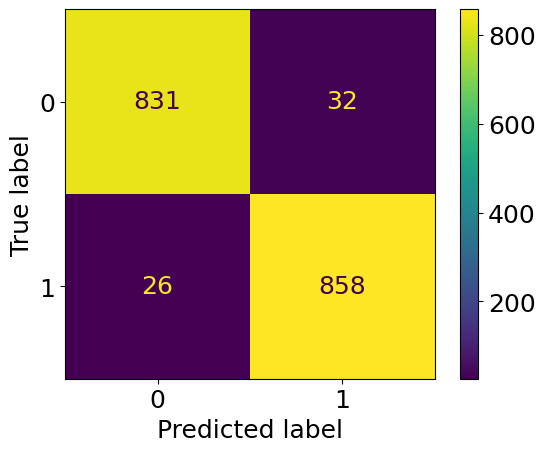

In [29]:
# Compute the confusion matrix for the test data using the predicted labels
confusionMatrix = confusion_matrix(y_test, y_pred, labels = pipe_linearSVC_best_params.classes_)

# Create a ConfusionMatrixDisplay object to display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = confusionMatrix, display_labels = pipe_linearSVC_best_params.classes_)

# Set the font size for the plot
plt.rc('font', size = 18)

# Plot the confusion matrix
disp.plot()

# Show the plot
plt.show()


Some extra notes: 

Here, the feature selection hasn't been done explicitly because it is a built-in function under the pipeline item TFIDF Vectorizer. There is no need to worry about it. 

There is no error observed unless expectations are not 100% accurate. This could be examined in detail as future developments. 

Another future development might be organizing the code for an outsider to run the code. But, almost every line of the code was commented on and explained. So it is most probably easy to do changes.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5d1f8779-1321-4bf6-bf43-45b15da2d641' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>